# Untrained, Physics-Informed Nueral Networks for Structured Illumination Microscopy

## -- Non-Linear SIM Demo --

Made by Zachary Burns

Uses the known SIM illumination patterns, mircoscope PSF, and background noise to define a physics-based forward model that is used as the loss function of the network during training. Training requires no ground truth data and is self-supervised.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, Conv2D, MaxPooling2D, UpSampling2D, Input, concatenate

In [2]:
# Check TF versions and CPU/GPU availability
print(tf.__version__)
print(tf.config.list_physical_devices())
print(tf.test.is_gpu_available)
print(tf.test.is_built_with_cuda())
print(tf.test.is_built_with_gpu_support())
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.4.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
<function is_gpu_available at 0x00000204DDD0E040>
True
True
Num CPUs Available:  1
Num GPUs Available:  1


## 1. Input Dimensions

In [3]:
num_im = 50      # Number of examples in dataset
frames = 25       # Number of sub-frames per example
im_dim = 480     # Image dimension (after super-res)
bg_lvl = 0       # Optional bg level subtraction

In [4]:
input_frames = np.zeros([num_im,im_dim,im_dim,frames])
gt_frames = np.zeros([num_im,im_dim,im_dim,1])
lr_frames = np.zeros([num_im,im_dim,im_dim,1])
patterns = np.zeros([frames,im_dim,im_dim,1])

## 2. Load Data

In [5]:
# Data name cane be one of: 'ccp', 'er', 'factin', or 'microtubules'
data_name = 'ccp'
dir_name = 'Data/NL_SIM/'

for i in range(1,num_im):
      
    for j in range(1,(frames+1)):
       
        input_path = dir_name+data_name+'/input_frames/'+str(i)+'_'+str(j)+'.png'
        input_temp = cv2.imread(input_path,0)
        input_temp = cv2.resize(input_temp,dsize=(im_dim,im_dim), interpolation=cv2.INTER_CUBIC)
        input_frames[i-1,:,:,j-1] = input_temp                  
    
    gt_path = dir_name+data_name+'/ground_truth/'+str(i)+'.png'
    gt_temp = cv2.imread(gt_path,0)
    gt_temp = cv2.resize(gt_temp,dsize=(im_dim,im_dim), interpolation=cv2.INTER_CUBIC)
    gt_temp = gt_temp.reshape([im_dim,im_dim,1])
    gt_frames[i-1,:,:,:] = gt_temp

    lr_path = dir_name+data_name+'/low_res/'+str(i)+'.png'
    lr_temp = cv2.imread(lr_path,0)
    lr_temp = cv2.resize(lr_temp,dsize=(im_dim,im_dim), interpolation=cv2.INTER_CUBIC)
    lr_temp = lr_temp.reshape([im_dim,im_dim,1])
    lr_frames[i-1,:,:,:] = lr_temp
    

for i in range(1,(frames+1)):
    
    pattern_path = dir_name+data_name+'/patterns/'+str(i)+'.png'
    pattern_temp = cv2.imread(pattern_path,0)
    pattern = cv2.resize(pattern_temp,dsize=(im_dim,im_dim), interpolation=cv2.INTER_CUBIC)  
    pattern = pattern.reshape([im_dim,im_dim,1])
    patterns[i-1,:,:,:] = pattern
            

## 3. Check and Normalize Data

In [6]:
print(np.amax(input_frames))
input_frames = input_frames - bg_lvl;
input_frames[input_frames<0] = 0
input_frames = input_frames/np.amax(input_frames)
print(np.amax(input_frames))
gt_fames = gt_frames/np.amax(gt_frames)
lr_frames = lr_frames/np.amax(lr_frames)
patterns = patterns/np.amax(patterns)
print(input_frames.shape)
print(gt_frames.shape)

255.0
1.0
(50, 480, 480, 25)
(50, 480, 480, 1)


Text(0.5, 1.0, 'Illumination pattern')

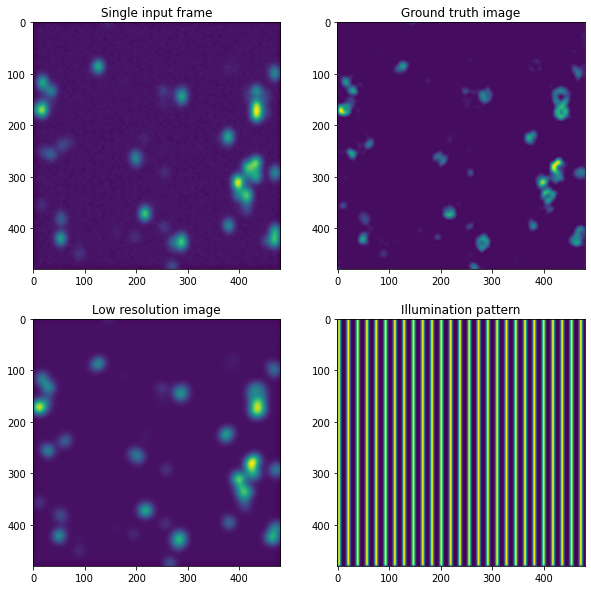

In [7]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(input_frames[0,:,:,1])
plt.title('Single input frame')
plt.subplot(2,2,2)
plt.imshow(gt_frames[0,:,:,:])
plt.title('Ground truth image')
plt.subplot(2,2,3)
plt.imshow(lr_frames[0,:,:,:])
plt.title('Low resolution image')
plt.subplot(2,2,4)
plt.imshow(patterns[0,:,:,:])
plt.title('Illumination pattern')

## 4. Define PSF

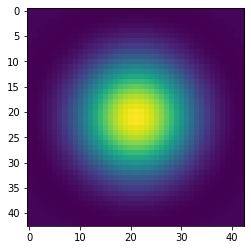

In [8]:
psf = cv2.imread(dir_name+data_name+'/psf.png',0)
plt.imshow(psf)
psf = np.reshape(psf,[np.ma.size(psf,0),np.ma.size(psf,0),1,1])

## 5. Define Network

In [9]:
k_size = 3

def u_net():
    
    inputs = Input((im_dim,im_dim,frames))
    block1 = Conv2D(32, (k_size, k_size), padding="same", activation = 'relu')(inputs)
    block2 = Conv2D(32, (k_size, k_size), padding="same", activation = 'relu')(block1)
    block2 = Conv2D(32, (k_size, k_size), padding="same", activation = 'relu')(block2)
    down1 = MaxPooling2D(pool_size=(2,2))(block2)
    block3 = Conv2D(64, (k_size, k_size), padding="same", activation = 'relu')(down1)
    block3 = Conv2D(64, (k_size, k_size), padding="same", activation = 'relu')(block3)
    down2 = MaxPooling2D(pool_size=(2,2))(block3)
    block4 = Conv2D(128, (k_size, k_size), padding="same", activation = 'relu')(down2)
    block4 = Conv2D(128, (k_size, k_size), padding="same", activation = 'relu')(block4)
    down3 = MaxPooling2D(pool_size=(2,2))(block4)
    block5 = Conv2D(256, (k_size, k_size), padding="same", activation = 'relu')(down3)
    block5 = Conv2D(256, (k_size, k_size), padding="same", activation = 'relu')(block5)
    up1 = UpSampling2D(size=(2,2))(block5)
    cat1 = concatenate([block4,up1])
    block6 = Conv2D(128, (k_size, k_size), padding="same", activation = 'relu')(cat1)
    block6 = Conv2D(128, (k_size, k_size), padding="same", activation = 'relu')(block6)
    up2 = UpSampling2D(size=(2,2))(block6)
    cat2 = concatenate([block3,up2])
    block7 = Conv2D(64, (k_size, k_size), padding="same", activation = 'relu')(cat2)
    block7 = Conv2D(64, (k_size, k_size), padding="same", activation = 'relu')(block7)
    up3 = UpSampling2D(size=(2,2))(block7)
    cat3 = concatenate([block2,up3])
    block8 = Conv2D(32, (k_size, k_size), padding="same", activation = 'relu')(cat3)
    block8 = Conv2D(32, (k_size, k_size), padding="same", activation = 'relu')(block8)
    block9 = Conv2D(32, (k_size, k_size), padding="same", activation = 'relu')(block8)
    output = Conv2D(1, (1, 1), padding="same")(block9)
    output = tf.keras.layers.ReLU(max_value=1.0)(output)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[output])
    
    return model

In [10]:
model = u_net()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 480, 25 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 480, 480, 32) 7232        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 480, 480, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 480, 480, 32) 9248        conv2d_1[0][0]                   
______________________________________________________________________________________________

## 6. Define Forward Model Loss Function

In [11]:
def SSIM_Loss(y_true, y_pred):
    return (1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))) 

In [12]:
def Physics_Loss(y_true, y_pred):
    
    loss = 0
    y_pred = tf.transpose(y_pred,(3,1,2,0))
    y_true = tf.transpose(y_true,(3,1,2,0))
    
    for i in range(0,(batch_size)):
        
        pred = y_pred[:,:,:,i-1]
        pred = tf.expand_dims(pred,3)
        # multiply predicted object by illumination patterns
        prod = tf.math.multiply(pred,patterns)
        # convolve with PSF
        conv = tf.nn.conv2d(prod,psf,strides=[1,1,1,1],padding='SAME',data_format='NHWC')    
        conv = tf.math.divide(tf.math.subtract(conv,tf.reduce_min(conv)),tf.math.subtract(tf.reduce_max(conv),tf.reduce_min(conv)))
       
        true = y_true[:,:,:,i-1]
        true = tf.expand_dims(true,3)

        im_loss = SSIM_Loss(conv,true) 
        loss = loss + im_loss
    
    return loss

## 8. Run Network Optimization

In [13]:
# Pick one of the data
ind = 21
single_input = input_frames[ind-1,:,:,:]
single_input = single_input.reshape([1,im_dim,im_dim,frames])
print(single_input.shape)

(1, 480, 480, 25)


In [14]:
learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate,
    decay_steps=50,
    decay_rate=0.90,
    staircase=True)

opt = tf.keras.optimizers.Adam(lr_schedule)
batch_size = 1
eps = 1000
l = Physics_Loss

model.compile(loss=l, optimizer=opt)
model_history = model.fit(x=single_input,y=single_input,epochs=eps,batch_size=batch_size)

Epoch 1/1000
1/1 [==============================] - 6s 6s/step - loss: 0.0764
Epoch 2/1000
1/1 [==============================] - 0s 343ms/step - loss: 0.9364
Epoch 3/1000
1/1 [==============================] - 0s 341ms/step - loss: 0.1557
Epoch 4/1000
1/1 [==============================] - 0s 344ms/step - loss: 0.0650
Epoch 5/1000
1/1 [==============================] - 0s 361ms/step - loss: 0.0607
Epoch 6/1000
1/1 [==============================] - 0s 337ms/step - loss: 0.0536
Epoch 7/1000
1/1 [==============================] - 0s 343ms/step - loss: 0.0745
Epoch 8/1000
1/1 [==============================] - 0s 346ms/step - loss: 0.0733
Epoch 9/1000
1/1 [==============================] - 0s 342ms/step - loss: 0.0451
Epoch 10/1000
1/1 [==============================] - 0s 352ms/step - loss: 0.0598
Epoch 11/1000
1/1 [==============================] - 0s 345ms/step - loss: 0.0525
Epoch 12/1000
1/1 [==============================] - 0s 357ms/step - loss: 0.0517
Epoch 13/1000
1/1 [=========

1/1 [==============================] - 0s 347ms/step - loss: 0.0362
Epoch 102/1000
1/1 [==============================] - 0s 347ms/step - loss: 0.0358
Epoch 103/1000
1/1 [==============================] - 0s 346ms/step - loss: 0.0345
Epoch 104/1000
1/1 [==============================] - 0s 348ms/step - loss: 0.0340
Epoch 105/1000
1/1 [==============================] - 0s 348ms/step - loss: 0.0341
Epoch 106/1000
1/1 [==============================] - 0s 347ms/step - loss: 0.0338
Epoch 107/1000
1/1 [==============================] - 0s 349ms/step - loss: 0.0325
Epoch 108/1000
1/1 [==============================] - 0s 345ms/step - loss: 0.0335
Epoch 109/1000
1/1 [==============================] - 0s 356ms/step - loss: 0.0323
Epoch 110/1000
1/1 [==============================] - 0s 349ms/step - loss: 0.0321
Epoch 111/1000
1/1 [==============================] - 0s 353ms/step - loss: 0.0316
Epoch 112/1000
1/1 [==============================] - 0s 349ms/step - loss: 0.0326
Epoch 113/1000
1/1 

1/1 [==============================] - 0s 385ms/step - loss: 0.0283
Epoch 200/1000
1/1 [==============================] - 0s 381ms/step - loss: 0.0283
Epoch 201/1000
1/1 [==============================] - 0s 372ms/step - loss: 0.0282
Epoch 202/1000
1/1 [==============================] - 0s 351ms/step - loss: 0.0281
Epoch 203/1000
1/1 [==============================] - 0s 354ms/step - loss: 0.0280
Epoch 204/1000
1/1 [==============================] - 0s 402ms/step - loss: 0.0280
Epoch 205/1000
1/1 [==============================] - 0s 383ms/step - loss: 0.0281
Epoch 206/1000
1/1 [==============================] - 0s 384ms/step - loss: 0.0286
Epoch 207/1000
1/1 [==============================] - 0s 362ms/step - loss: 0.0298
Epoch 208/1000
1/1 [==============================] - 0s 360ms/step - loss: 0.0291
Epoch 209/1000
1/1 [==============================] - 0s 356ms/step - loss: 0.0281
Epoch 210/1000
1/1 [==============================] - 0s 368ms/step - loss: 0.0278
Epoch 211/1000
1/1 

1/1 [==============================] - 0s 365ms/step - loss: 0.0262
Epoch 298/1000
1/1 [==============================] - 0s 354ms/step - loss: 0.0261
Epoch 299/1000
1/1 [==============================] - 0s 352ms/step - loss: 0.0261
Epoch 300/1000
1/1 [==============================] - 0s 356ms/step - loss: 0.0261
Epoch 301/1000
1/1 [==============================] - 0s 378ms/step - loss: 0.0261
Epoch 302/1000
1/1 [==============================] - 0s 366ms/step - loss: 0.0262
Epoch 303/1000
1/1 [==============================] - 0s 356ms/step - loss: 0.0261
Epoch 304/1000
1/1 [==============================] - 0s 356ms/step - loss: 0.0260
Epoch 305/1000
1/1 [==============================] - 0s 378ms/step - loss: 0.0260
Epoch 306/1000
1/1 [==============================] - 0s 398ms/step - loss: 0.0259
Epoch 307/1000
1/1 [==============================] - 0s 401ms/step - loss: 0.0259
Epoch 308/1000
1/1 [==============================] - 0s 389ms/step - loss: 0.0259
Epoch 309/1000
1/1 

1/1 [==============================] - 0s 351ms/step - loss: 0.0256
Epoch 396/1000
1/1 [==============================] - 0s 360ms/step - loss: 0.0261
Epoch 397/1000
1/1 [==============================] - 0s 356ms/step - loss: 0.0262
Epoch 398/1000
1/1 [==============================] - 0s 355ms/step - loss: 0.0256
Epoch 399/1000
1/1 [==============================] - 0s 357ms/step - loss: 0.0263
Epoch 400/1000
1/1 [==============================] - 0s 364ms/step - loss: 0.0261
Epoch 401/1000
1/1 [==============================] - 0s 362ms/step - loss: 0.0256
Epoch 402/1000
1/1 [==============================] - 0s 349ms/step - loss: 0.0262
Epoch 403/1000
1/1 [==============================] - 0s 355ms/step - loss: 0.0256
Epoch 404/1000
1/1 [==============================] - 0s 373ms/step - loss: 0.0259
Epoch 405/1000
1/1 [==============================] - 0s 405ms/step - loss: 0.0256
Epoch 406/1000
1/1 [==============================] - 0s 404ms/step - loss: 0.0256
Epoch 407/1000
1/1 

1/1 [==============================] - 0s 364ms/step - loss: 0.0258
Epoch 494/1000
1/1 [==============================] - 0s 357ms/step - loss: 0.0260
Epoch 495/1000
1/1 [==============================] - 0s 353ms/step - loss: 0.0258
Epoch 496/1000
1/1 [==============================] - 0s 355ms/step - loss: 0.0258
Epoch 497/1000
1/1 [==============================] - 0s 352ms/step - loss: 0.0257
Epoch 498/1000
1/1 [==============================] - 0s 359ms/step - loss: 0.0256
Epoch 499/1000
1/1 [==============================] - 0s 352ms/step - loss: 0.0257
Epoch 500/1000
1/1 [==============================] - 0s 349ms/step - loss: 0.0255
Epoch 501/1000
1/1 [==============================] - 0s 353ms/step - loss: 0.0256
Epoch 502/1000
1/1 [==============================] - 0s 368ms/step - loss: 0.0255
Epoch 503/1000
1/1 [==============================] - 0s 359ms/step - loss: 0.0255
Epoch 504/1000
1/1 [==============================] - 0s 349ms/step - loss: 0.0254
Epoch 505/1000
1/1 

1/1 [==============================] - 0s 398ms/step - loss: 0.0242
Epoch 592/1000
1/1 [==============================] - 0s 407ms/step - loss: 0.0241
Epoch 593/1000
1/1 [==============================] - 0s 390ms/step - loss: 0.0241
Epoch 594/1000
1/1 [==============================] - 0s 374ms/step - loss: 0.0241
Epoch 595/1000
1/1 [==============================] - 0s 371ms/step - loss: 0.0241
Epoch 596/1000
1/1 [==============================] - 0s 355ms/step - loss: 0.0241
Epoch 597/1000
1/1 [==============================] - 0s 350ms/step - loss: 0.0241
Epoch 598/1000
1/1 [==============================] - 0s 378ms/step - loss: 0.0241
Epoch 599/1000
1/1 [==============================] - 0s 373ms/step - loss: 0.0241
Epoch 600/1000
1/1 [==============================] - 0s 358ms/step - loss: 0.0241
Epoch 601/1000
1/1 [==============================] - 0s 359ms/step - loss: 0.0241
Epoch 602/1000
1/1 [==============================] - 0s 368ms/step - loss: 0.0241
Epoch 603/1000
1/1 

1/1 [==============================] - 0s 371ms/step - loss: 0.0236
Epoch 690/1000
1/1 [==============================] - 0s 357ms/step - loss: 0.0236
Epoch 691/1000
1/1 [==============================] - 0s 361ms/step - loss: 0.0236
Epoch 692/1000
1/1 [==============================] - 0s 402ms/step - loss: 0.0235
Epoch 693/1000
1/1 [==============================] - 0s 395ms/step - loss: 0.0235
Epoch 694/1000
1/1 [==============================] - 0s 364ms/step - loss: 0.0235
Epoch 695/1000
1/1 [==============================] - 0s 360ms/step - loss: 0.0235
Epoch 696/1000
1/1 [==============================] - 0s 352ms/step - loss: 0.0235
Epoch 697/1000
1/1 [==============================] - 0s 358ms/step - loss: 0.0235
Epoch 698/1000
1/1 [==============================] - 0s 353ms/step - loss: 0.0235
Epoch 699/1000
1/1 [==============================] - 0s 353ms/step - loss: 0.0235
Epoch 700/1000
1/1 [==============================] - 0s 362ms/step - loss: 0.0235
Epoch 701/1000
1/1 

1/1 [==============================] - 0s 412ms/step - loss: 0.0231
Epoch 788/1000
1/1 [==============================] - 0s 406ms/step - loss: 0.0233
Epoch 789/1000
1/1 [==============================] - 0s 402ms/step - loss: 0.0234
Epoch 790/1000
1/1 [==============================] - 0s 397ms/step - loss: 0.0231
Epoch 791/1000
1/1 [==============================] - 0s 380ms/step - loss: 0.0233
Epoch 792/1000
1/1 [==============================] - 0s 368ms/step - loss: 0.0233
Epoch 793/1000
1/1 [==============================] - 0s 350ms/step - loss: 0.0231
Epoch 794/1000
1/1 [==============================] - 0s 354ms/step - loss: 0.0233
Epoch 795/1000
1/1 [==============================] - 0s 397ms/step - loss: 0.0232
Epoch 796/1000
1/1 [==============================] - 0s 393ms/step - loss: 0.0231
Epoch 797/1000
1/1 [==============================] - 0s 376ms/step - loss: 0.0233
Epoch 798/1000
1/1 [==============================] - 0s 369ms/step - loss: 0.0232
Epoch 799/1000
1/1 

1/1 [==============================] - 0s 394ms/step - loss: 0.0232
Epoch 886/1000
1/1 [==============================] - 0s 424ms/step - loss: 0.0228
Epoch 887/1000
1/1 [==============================] - 0s 461ms/step - loss: 0.0230
Epoch 888/1000
1/1 [==============================] - 0s 430ms/step - loss: 0.0231
Epoch 889/1000
1/1 [==============================] - 0s 371ms/step - loss: 0.0228
Epoch 890/1000
1/1 [==============================] - 0s 354ms/step - loss: 0.0231
Epoch 891/1000
1/1 [==============================] - 0s 430ms/step - loss: 0.0230
Epoch 892/1000
1/1 [==============================] - 0s 447ms/step - loss: 0.0228
Epoch 893/1000
1/1 [==============================] - 0s 430ms/step - loss: 0.0232
Epoch 894/1000
1/1 [==============================] - 0s 376ms/step - loss: 0.0229
Epoch 895/1000
1/1 [==============================] - 0s 358ms/step - loss: 0.0228
Epoch 896/1000
1/1 [==============================] - 0s 393ms/step - loss: 0.0231
Epoch 897/1000
1/1 

1/1 [==============================] - 0s 422ms/step - loss: 0.0226
Epoch 984/1000
1/1 [==============================] - 0s 426ms/step - loss: 0.0226
Epoch 985/1000
1/1 [==============================] - 0s 375ms/step - loss: 0.0226
Epoch 986/1000
1/1 [==============================] - 0s 350ms/step - loss: 0.0226
Epoch 987/1000
1/1 [==============================] - 0s 352ms/step - loss: 0.0226
Epoch 988/1000
1/1 [==============================] - 0s 354ms/step - loss: 0.0225
Epoch 989/1000
1/1 [==============================] - 0s 357ms/step - loss: 0.0225
Epoch 990/1000
1/1 [==============================] - 0s 361ms/step - loss: 0.0225
Epoch 991/1000
1/1 [==============================] - 0s 377ms/step - loss: 0.0226
Epoch 992/1000
1/1 [==============================] - 0s 378ms/step - loss: 0.0226
Epoch 993/1000
1/1 [==============================] - 0s 353ms/step - loss: 0.0226
Epoch 994/1000
1/1 [==============================] - 0s 350ms/step - loss: 0.0225
Epoch 995/1000
1/1 

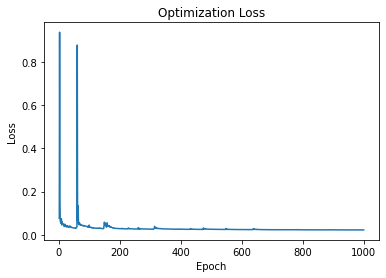

In [15]:
plt.plot(np.linspace(1,eps,num=eps),model_history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Optimization Loss')
plt.subplots_adjust(wspace = 0.5)

## 8. Plot PINN Results

(1, 480, 480, 1)


Text(0.5, 1.0, 'Diffraction limited image')

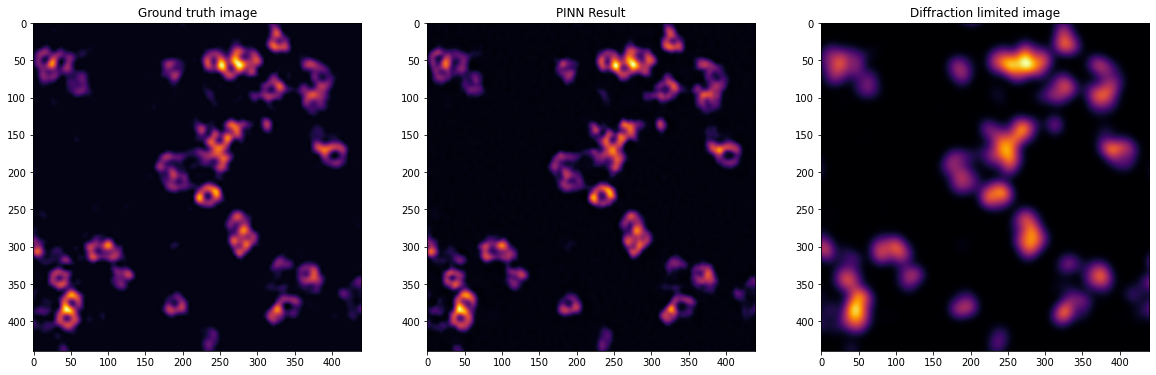

In [16]:
predicted = model.predict(single_input)

print(predicted.shape)
predicted = predicted.reshape([im_dim,im_dim])
predicted = predicted[20:(im_dim-20),20:(im_dim-20)]
predicted = (predicted-np.amin(predicted))/(np.amax(predicted)-np.amin(predicted))

gt = gt_frames[ind-1,:,:,:]
gt = gt[20:(im_dim-20),20:(im_dim-20)]
gt = (gt-np.amin(gt))/(np.amax(gt)-np.amin(gt))
gt = gt.reshape([(im_dim-40),(im_dim-40)])

lowres = lr_frames[ind-1,:,:,:]
lowres = lowres[20:(im_dim-20),20:(im_dim-20)]
lowres = (lowres-np.amin(lowres))/(np.amax(lowres)-np.amin(lowres))
lowres = lowres.reshape([(im_dim-40),(im_dim-40)])

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(gt,cmap='inferno')
plt.title('Ground truth image')
plt.subplot(1,3,2)
plt.imshow(predicted,cmap='inferno')
plt.title('PINN Result')
plt.subplot(1,3,3)
plt.imshow(lowres,cmap='inferno')
plt.title('Diffraction limited image')